# Introduction

There are a wide variety of proposed solutions to the heavy hitters problem, ranging from [Poplar](https://eprint.iacr.org/2021/017.pdf) to [STAR](https://brave.com/research/files/star-ccs-2022.pdf). Conveniently, both Poplar and STAR can be viewed as a form of [VDAF](https://cfrg.github.io/draft-irtf-cfrg-vdaf/draft-irtf-cfrg-vdaf.html), or verifiable distributed aggregation function. A VDAF is a multi-party protocol between clients and one or more aggregators for computing aggregate statistics. The protocol consists of the following phases:
 
- Sharding: Computing input shares from an individual measurement. For convenience, we also refer to this phase as the Uploading phase.
- Preparation: Conversion and verification of input shares to output shares compatible with the aggregation function being computed.
- Aggregation: Combining a sequence of output shares into an aggregate share.
- Unsharding: Combining a sequence of aggregate shares into an aggregate result. For convenience, we also refer to this phase as the Finalization phase.

# Protocol Costs

Each of these phases has an associated cost, where cost is measured in terms of network messages, bandwidth, and computation. For convenience, let $\mathsf{C}_{\mathsf{phase}}^{\mathsf{property}}(\pi)$ be the cost of some property of a particular phrase for a VDAF $\pi$. For example, $\mathsf{C}_{\mathsf{upload}}^{\mathsf{bw}}(\mathsf{STAR})$ is the bandwidth upload cost of $\mathsf{STAR}$.

In [37]:
class VDAF(object):
    def __init__(self):
        pass
    def upload_cost_bw(self):
        raise Exception("implement me")
    def upload_cost_rounds(self):
        raise Exception("implement me")
    def upload_cost_cpu(self):
        raise Exception("implement me")
    def prepare_cost_bw(self):
        raise Exception("implement me")
    def prepare_cost_rounds(self):
        raise Exception("implement me")
    def prepare_cost_cpu(self):
        raise Exception("implement me")
    def aggregate_cost_bw(self):
        raise Exception("implement me")
    def aggregate_cost_rounds(self):
        raise Exception("implement me")
    def aggregate_cost_cpu(self):
        raise Exception("implement me")
    def finalize_cost_bw(self):
        raise Exception("implement me")
    def finalize_cost_rounds(self):
        raise Exception("implement me")
    def finalize_cost_cpu(self):
        raise Exception("implement me")

The units of cost for rounds and bandwidth are the number of rounds and bytes, respectively. However, the computation cost units vary. They may be in terms of AES operations, scalar multipliations in a prime-order group, or some other operation. For convenience, we assume there exists a handful of standard operations for these things, and denote their cost symbolically.

<!-- TODO(caw): introduce different units for computation cost that are relevant -->

## STAR

The STAR protocol, described in [this draft specification](https://shivankaul.com/star-spec/draft-dss-star.html), can be mapped to a VDAF in the following way.

- Sharding/Uploading: Run the randomness phase of the protocol to boost the entropy of the client input measurement and send a report derived from this randomness output to the aggregator.
- Preparation: For variants of STAR that use verifiable secret sharing (VSS) to prevent corrupt reports, the aggregator locally runs the VSS share verification algorithm to filter out invalid reports.
- Aggregation: The aggregator locally runs the secret share recovery process using the report shares in a batch to decrypt each report and recover the heavy hitter measurement and the per-client associated auxiliary information.
- Unsharding: This is a no-op.

We assume a verison of STAR that uses verifiable secret sharing over the the ristretto255 prime-order group, and using a VOPRF configured with ristretto255 as the prime-order group. This means that each element and scalar value sent on the wire is 32 bytes. We denote the size of group elements and scalars as `ELEMENT_SIZE` and `SCALAR_SIZE`, respectively.

In [43]:
from sympy import symbols

# TODO(caw): make these parameters for the STAR system
ELEMENT_SIZE = 32
SCALAR_SIZE = 32
HEAVY_HITTER_SIZE = 64

THRESHOLD, COST_VSS_VERIFY, COST_VSS_SHARE, COST_VSS_RECOVER, COST_AEAD = symbols('T VSS_VERIFY VSS_SHARE VSS_RECOVER AEAD')

class STAR(VDAF):
    def __init__(self):
        pass

    # Upload phase: Run the randomness phase of the protocol to boost 
    # the entropy of the client input measurement and send a report 
    # derived from this randomness output to the aggregator.
    def upload_cost_bw(self):
        def upload_cost_bw_one():
            return ELEMENT_SIZE + \
                (ELEMENT_SIZE + 2*SCALAR_SIZE) + \
                (2*SCALAR_SIZE + HEAVY_HITTER_SIZE + (THRESHOLD * ELEMENT_SIZE)) # STAR report size
        return upload_cost_bw_one()
    def upload_cost_msg(self):
        return 3 # 2 for randomness server, 1 for upload
    def upload_cost_cpu(self):
        # TODO(caw): make this more concrete in terms of group operations
        return COST_VSS_SHARE + COST_AEAD
        
    # Prepare phase: For variants of STAR that use verifiable secret 
    # sharing (VSS) to prevent corrupt reports, the aggregator locally 
    # runs the VSS share verification algorithm to filter out invalid reports.
    def prepare_cost_bw(self):
        return 0
    def prepare_cost_msg(self):
        return 0
    def prepare_cost_cpu(self):
        # TODO(caw): make this more concrete in terms of group operations
        return COST_VSS_VERIFY * THRESHOLD
    
    # Aggregate phase: The aggregator locally runs the secret share 
    # recovery process using the report shares in a batch to decrypt 
    # each report and recover the heavy hitter measurement and the 
    # per-client associated auxiliary information.
    def aggregate_cost_bw(self):
        return 0
    def aggregate_cost_msg(self):
        return 0
    def aggregate_cost_cpu(self):
        # This should be the cost of polynomial interpolation, plus the cost of report decryption
        return COST_VSS_RECOVER + COST_AEAD
        
    # Finalzie phase: This phase is a no-op as the final output is already computed during the aggregate phase.
    def finalize_cost_bw(self):
        return 0
    def finalize_cost_msg(self):
        return 0
    def finalize_cost_cpu(self):
        return 0

In [44]:
import pandas as pd

star = STAR()
data = [
    [star.upload_cost_cpu(), star.upload_cost_bw(), star.upload_cost_msg()], 
    [star.prepare_cost_cpu(), star.prepare_cost_bw(), star.prepare_cost_msg()], 
    [star.aggregate_cost_cpu(), star.aggregate_cost_bw(), star.aggregate_cost_msg()], 
    [star.finalize_cost_cpu(), star.finalize_cost_bw(), star.finalize_cost_msg()], 
]
single_df = pd.DataFrame(data, columns=["Per-report CPU", "Per-report  Bandwidth (B)", "Per-report Messages"])
single_df.index = ["Upload", "Prepare", "Aggregate", "Finalize"]
single_df

,Per-report CPU,Per-report Bandwidth (B),Per-report Messages
Upload,AEAD + VSS_SHARE,32*T + 256,3
Prepare,T*VSS_VERIFY,0,0
Aggregate,AEAD + VSS_RECOVER,0,0
Finalize,0,0,0


In [45]:
total_data = data
for i, row in enumerate(total_data):
    for j, col in enumerate(row):
        total_data[i][j] *= THRESHOLD
total_df = pd.DataFrame(data, columns=["Batch CPU", "Batch Bandwidth (B)", "Batch Messages"])
total_df.index = ["Upload", "Prepare", "Aggregate", "Finalize"]
total_df

,Batch CPU,Batch Bandwidth (B),Batch Messages
Upload,T*(AEAD + VSS_SHARE),T*(32*T + 256),3*T
Prepare,T**2*VSS_VERIFY,0,0
Aggregate,T*(AEAD + VSS_RECOVER),0,0
Finalize,0,0,0


## Poplar

The Poplar protocol, described in [this draft specification](https://cfrg.github.io/draft-irtf-cfrg-vdaf/draft-irtf-cfrg-vdaf.html#name-poplar1), is mapped to a VDAF in the following way.

- Sharding/Uploading: Clients split their measurement into shares for each aggregator and sends a report to the primary aggregator.
- Preparation: Aggregators run an interactive protocol with the collector for evaluating an iDPF.
- Aggregation: Aggregators locally combine output shares to yield aggregate shares.
- Unsharding: The collector locally combines aggregate shares to yield an aggregate result.

The preparation, aggregation, and unsharding phases are driven by the collector based on a set of candidate prefixes, starting from an empty set, where each sequence of phases yields a new candidate set of prefixes. As a result, this sequence of phases is run until the final heavy hitters are revealed. The number of times this sequence is run depends on the heavy hitter threshold, number of reports in a batch, and the length of each input string.

For comparison, we assume a verison of Poplar that uses an iDPF over two different fields: one field for leaf nodes that has elements 32 bytes in size, and another field for inner nodes that has elements 8 bytes in size. We also assume that the heavy hitter inputs are tokenized one bit at a time (denoted by the `SKIP_FACTOR` parameter below). Finally, we assume a cryptographic seed size of 16 bytes.

In [50]:
from sympy import symbols

# TODO(caw): make these parameters for Poplar
SKIP_FACTOR = 1
seed_size = 16
inner_field_encoded_size = 8
leaf_field_encoded_size = 32

# TODO(caw): make these global parameters shared by the heavy hitter systems
# HEAVY_HITTER_SIZE = 64
# THRESHOLD = 8
HEAVY_HITTER_SIZE, THRESHOLD, SKIP_FACTOR = symbols('N T K')

# See: https://github.com/cloudflareresearch/vdaf/blob/main/fig/bandwidth-comparison.py
class Poplar1(VDAF):
    def __init__(self):
        pass

    # Upload phase: TODO
    def upload_cost_bw(self):
        public_share = 0
        leader_share = 0
        helper_share = 0
        
        # IDPF - control bits
        public_share += ((2*HEAVY_HITTER_SIZE + 7) / 8)

        # IDPF - seed_cw
        public_share += HEAVY_HITTER_SIZE * seed_size

        # IDPF - w_cw - data and auth
        #
        # Skipping removes the correction words from skipped levels.
        public_share += 2 * ((HEAVY_HITTER_SIZE-1)/SKIP_FACTOR) * inner_field_encoded_size # inner nodes
        public_share += 2 * leaf_field_encoded_size # leaf nodes

        # IDPF - keys
        leader_share += seed_size
        helper_share += seed_size

        # Sketch - corr seeds
        leader_share += seed_size
        helper_share += seed_size

        # Sketch - corr pairs
        #
        # Skipping removes the correction words from skipped levels.
        leader_share += 2 * ((HEAVY_HITTER_SIZE-1)/SKIP_FACTOR) * inner_field_encoded_size # inner nodes
        leader_share += 2 * leaf_field_encoded_size # leaf nodes
        helper_share += 2 * ((HEAVY_HITTER_SIZE-1)/SKIP_FACTOR) * inner_field_encoded_size # inner nodes
        helper_share += 2 * leaf_field_encoded_size # leaf nodes
        
        # TODO(caw): how do we want to compare leader and helper costs? Pick the larger of the two?
        return public_share + leader_share
        
    def upload_cost_msg(self):
        return 1
    def upload_cost_cpu(self):
        return 0 # TODO(caw): writeme
        
    # Prepare phase: TODO
    def prepare_cost_bw(self):
        aggregator_sent = 0

        # round 1
        aggregator_sent += 3 * ((HEAVY_HITTER_SIZE-1)/SKIP_FACTOR) * inner_field_encoded_size
        aggregator_sent += 3 * leaf_field_encoded_size

        # round 2
        aggregator_sent += ((HEAVY_HITTER_SIZE-1)/SKIP_FACTOR) * inner_field_encoded_size
        aggregator_sent += leaf_field_encoded_size
    def prepare_cost_msg(self):
        return 2 * ((HEAVY_HITTER_SIZE-1)/SKIP_FACTOR)
    def prepare_cost_cpu(self):
        return 0 # TODO(caw): writeme
    
    # Aggregate phase: TODO
    def aggregate_cost_bw(self):
        return 0
    def aggregate_cost_msg(self):
        return 0
    def aggregate_cost_cpu(self):
        return 0 # TODO(caw): cost of aggregate
        
    # Finalize phase: TODO
    def finalize_cost_bw(self):
        return 0
    def finalize_cost_msg(self):
        return 0
    def finalize_cost_cpu(self):
        return 0 # TODO(caw): cost of aggregate

In [51]:
import pandas as pd

poplar = Poplar1()
data = [
    [poplar.upload_cost_cpu(), poplar.upload_cost_bw(), poplar.upload_cost_msg()], 
    [poplar.prepare_cost_cpu(), poplar.prepare_cost_bw(), poplar.prepare_cost_msg()], 
    [poplar.aggregate_cost_cpu(), poplar.aggregate_cost_bw(), poplar.aggregate_cost_msg()], 
    [poplar.finalize_cost_cpu(), poplar.finalize_cost_bw(), poplar.finalize_cost_msg()], 
]
single_df = pd.DataFrame(data, columns=["Per-report CPU", "Per-report  Bandwidth (B)", "Per-report Messages"])
single_df.index = ["Upload", "Prepare", "Aggregate", "Finalize"]
single_df

,Per-report CPU,Per-report Bandwidth (B),Per-report Messages
Upload,0,65*N/4 + 1287/8 + 32*(N - 1)/K,1
Prepare,0,None,2*(N - 1)/K
Aggregate,0,0,0
Finalize,0,0,0


# Application Cost

The section above discusses the cost of a single run of the protocol for collecting heavy hitters over a batch of client data. It fails to take the specifics of applications and data into account. The distribution of heavy hitters amongst a set of client reports can influence how an application chooses to run each of the protocols, and therefore has an impact on the overall cost. This is particularly important for Poplar. 

As an example, consider the best case scenario for Poplar, wherein the number of reports from clients matches the heavy hitter threshold, and each of the reports corresponds to the same heavy hitter value. In this case, a single run of Poplar would successfully reveal this heavy hitter to the application with minimal cost. Now consider the worst case scenario: where for a given set of reports, every possible value of heavy hitter appears $t-1$ times in the set, where $t$ is the threshold. In this case, Poplar would be maximally expensive.

To further complicate matters, Poplar is designed such that client reports can be used in at most one protocol run. This means applications need to make a tradeoff between cost and utility of the protocol. They could, for example, seek to maximize the client report batch size in order to increase the probability of collecting meaningful heavy hitters, although this approach would come at increased cost. 

In order to meaningfully compare STAR and Poplar, we need to consider the application cost and their measurement strategy. In practice, there are two common questions applications might seek to answer:

1. What are the heavy hitters shared by at least $t$ clients? This is referred to as an exploratory query.
2. Out of a set of candidate heavy hitters, are any of them shared by at least $t$ clients? This is referred to as a state query?

To compare STAR and Poplar, we'll use these two types of queries for varying application parameters. 

<!-- 
TODO(caw): continueme - given distribution D over a set C of client reports, and probability p that the measurement yields a heavy hitter value, how big should C be? Is there a better way to compare STAR and Poplar in this case? Maybe take a real-world database and its distribution, compute the number of elements that would need to be in a subset to reach a heavy hitter for a given threshold, and then compare the cost?

https://catalog.data.gov/dataset/popular-baby-names/resource/02e8f55e-2157-4cb2-961a-2aabb75cbc8b 
-->

## Exploratory Query Cost

For this type of query, we parameterize a dataset by the following values:

1. Input heavy hitter string length ($N$);
2. Size of the set of possible input strings, i.e., the size of input heavy hitter domain ($D$);
3. Number of samples to draw from the set of input strings ($S$); and
4. Threshold value ($T$). 

The following table shows the performance of STAR (using the [open source implementation](https://github.com/chris-wood/star-go)) and Poplar (using the [open source reference implementation](https://github.com/henrycg/heavyhitters)) under various choices of these parameters. Instructions to reproduce this data can be found [here](https://github.com/chris-wood/heavy-hitter-comparison/blob/main/README.md).

In [ ]:
## TODO(caw): generate table from the formatted JSON files
# import pandas as pd
#
# data = [
#     [poplar.upload_cost_cpu(), poplar.upload_cost_bw(), poplar.upload_cost_msg()], 
#     [poplar.prepare_cost_cpu(), poplar.prepare_cost_bw(), poplar.prepare_cost_msg()], 
#     [poplar.aggregate_cost_cpu(), poplar.aggregate_cost_bw(), poplar.aggregate_cost_msg()], 
#     [poplar.finalize_cost_cpu(), poplar.finalize_cost_bw(), poplar.finalize_cost_msg()], 
# ]
# single_df = pd.DataFrame(data, columns=["Per-report CPU", "Per-report  Bandwidth (B)", "Per-report Messages"])
# single_df.index = ["Upload", "Prepare", "Aggregate", "Finalize"]
# single_df

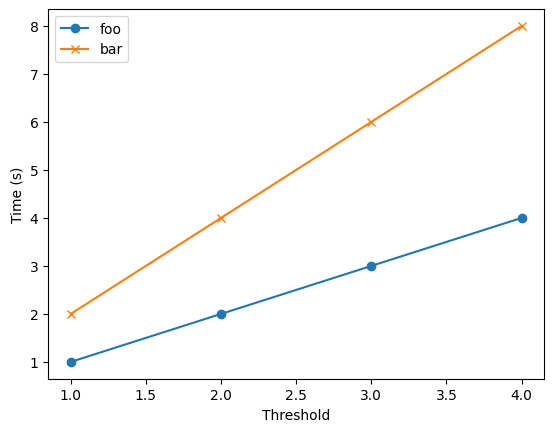

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

x = np.array([1,2,3,4])
y1 = np.array([1,2,3,4])
y2 = y1 * 2

plt.plot(x, y1, marker='o', label="foo")
plt.plot(x, y2, marker='x', label="bar")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Time (s)")
plt.show()

# Open Questions

- Should the cost be parameterized per-report, or for a single run of the protocol (a batch)?
- Should we decompose the costs of individual operations like secret sharing and iDPF evaluation?